<img width="200" style="float:left" 
     src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Apache_Spark_logo.svg" />

# Sections
* [Description](#0)
* [1. Setup](#1)
  * [1.1 Start Hadoop](#1.1)  
  * [1.2 Search for Spark Installation](#1.2)
  * [1.3 Create SparkSession](#1.3)
* [2. Lab](#2)
  * [2.1 Check Files](#2.1)
  * [2.2 Read raw DataFrame](#2.3)
  * [2.3 Transform raw DataFrame](#2.3)
  * [2.4 Write DataFrame to std](#2.4)
  * [2.5 Code improvements](#2.5)
* [3. TearDown](#3)
  * [3.1 Stop Hadoop](#3.1)

<a id='0'></a>
## Description
<p>
<div>The goals for this lab are:</div>
<ul>    
    <li>Get familiar with Spark DataFrames API</li>
    <li>Apply some transformations using Spark DataFrames API</li>
    <li>Promote data from raw to std layer in the datalake using Spark DataFrames API</li>
</ul>    
</p>
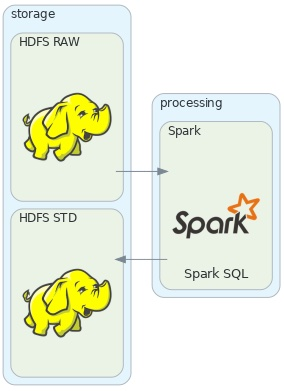

<a id='1'></a>
## 1. Setup

Since we are going to process data stored from HDFS let's start the service

<a id='1.1'></a>
### 1.1 Start Hadoop

Start Hadoop
Open a terminal and execute
```sh
hadoop-start.sh
```

<a id='1.2'></a>
### 1.2 Search for Spark Installation 
This step is required just because we are working in the course environment.

In [14]:
import findspark
findspark.init()

I'm changing pandas max column width property to improve data displaying

In [15]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

<a id='1.3'></a>
### 1.3 Create SparkSession

By setting this environment variable we can include extra libraries in our Spark cluster

In [16]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'

The first thing always is to create the SparkSession

In [17]:
from pyspark.sql.session import SparkSession

spark = SparkSession.builder\
.appName("Twitter RAW to STD - DataFrames")\
.config("spark.sql.warehouse.dir","hdfs://localhost:9000/warehouse")\
.config("spark.sql.legacy.timeParserPolicy","LEGACY")\
.config("spark.sql.sources.partitionOverwriteMode","dynamic")\
.enableHiveSupport()\
.getOrCreate()

<a id='2'></a>
## 2. Lab

<a id='2.1'></a>
### 2.1 Check  Files

In order to complete this lab you need to previosly complete **'NiFi Lab Twitter'**.

Check you have the data ready in HDFS

http://localhost:50070/explorer.html#/datalake/raw/twitter/bitcoin/

<a id='2.2'></a>
### 2.2 Read Raw DataFrame

We can infer the schema of the underlying json files by setting this option during the reading operation.<br/>
This is not recommended in production workloads as is very expensive (Spark will scan all the files in order to determine all the columns)


In [18]:
tweets_raw = spark.read.option("inferSchema","true")\
                       .option("recursiveFileLookup", "true")\
                       .json("hdfs://localhost:9000/datalake/raw/twitter/ps5/")
                       
tweets_raw.limit(5).toPandas()

contributors coordinates                      created_at display_text_range  \
0         None        None  Mon Dec 06 17:00:00 +0000 2021          [12, 140]   
1         None        None  Mon Dec 06 17:00:00 +0000 2021           [0, 140]   
2         None        None  Mon Dec 06 17:00:00 +0000 2021            [0, 36]   
3         None        None  Mon Dec 06 17:00:00 +0000 2021               None   
4         None        None  Mon Dec 06 17:00:00 +0000 2021               None   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 entities  \
0                                                                                                                                                                                                                                                                                                                                                                                            ([], None, [], [(twitter.com/i/web/status/1…, https://twitter.com/i/web/status/1467901649532379138, [116, 139], https://t.co/lpkvnNXk0R)], [(1382411562112192517, 1382411562112192517, [0, 11], MicahChips ☭⃠, CrispsCold)])   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                          ([], None, [], [(twitter.com/i/web/status/1…, https://twitter.com/i/web/status/1467901649922396166, [117, 140], https://t.co/8XtDEb0nQE)], [])   
2  ([], [(None, Spiderman Everybody GIF, pic.twitter.com/CsmcAzjhHe, https://twitter.com/ecjaxson/status/1467901649758957568/photo/1, 1467901639369633798, 1467901639369633798, [37, 60], http://pbs.twimg.com/tweet_video_thumb/FF8Iw4PXMAYaif1.jpg, https://pbs.twimg.com/tweet_video_thumb/FF8Iw4PXMAYaif1.jpg, Row(large=Row(h=374, resize='fit', w=498), medium=Row(h=374, resize='fit', w=498), small=Row(h=374, resize='fit', w=498), thumb=Row(h=150, resize='crop', w=150)), None, None, None, None, photo, https://t.co/CsmcAzjhHe)], [], [], [(22841103, 22841103, [0, 15], Insomniac Games, insomniacgames)])   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                         ([([49, 68], SpiderManNoWayHome), ([120, 133], SpiderManPS5)], None, [], [], [(846923375209594880, 846923375209594880, [3, 14], MCU - The Direct, MCU_Direct)])   
4                                                                                                                                                                                                                                                                                                                                                                                  ([], None, [], [(wakefieldexpress.co.uk/news/crime/pro…, https://www.wakefieldexpress.co.uk/news/crime/prolific-burglar

In [19]:
tweets_raw.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |-- description: string (nullable = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- i

Is better if we set up the schema during data reading.

In [27]:
schema="""
created_at string,
id bigint,
id_str string,
text string,
source string,
truncated boolean,
in_reply_to_status_id bigint,
in_reply_to_status_id_str string,
in_reply_to_user_id bigint,
in_reply_to_user_id_str string,
in_reply_to_screen_name string,
`user` struct<
            id:bigint,
            id_str:string,
            name:string,
            screen_name:string,
            location:string,
            url:string,
            description:string,
            protected:boolean,
            verified:boolean,
            followers_count:bigint,
            friends_count:bigint,
            listed_count:bigint,
            favourites_count:bigint,
            statuses_count:bigint,
            created_at:string,
            profile_banner_url:string,
            profile_image_url_https:string,
            default_profile:boolean,
            default_profile_image:boolean,
            withheld_in_countries: array<string>,
            withheld_scope:string,
            geo_enabled:boolean
            >,
coordinates struct <
            coordinates:array<float>,
            type:string
            >,
place struct<
            country:string,
            country_code:string,
            full_name:string,
            place_type:string,
            url:string
            >,
quoted_status_id bigint,
quoted_status_id_str string,
is_quote_status boolean,
quote_count bigint,
reply_count bigint,
retweet_count bigint,
favorite_count bigint,
entities struct<
            user_mentions:array<struct<screen_name:string>>,
            hashtags:array<struct<text:string>>, 
            media:array<struct<expanded_url:string>>, 
            urls:array<struct<expanded_url:string>>, 
            symbols:array<struct<text:string>>
            >,
favorited boolean,
retweeted boolean,
possibly_sensitive boolean,
filter_level string,
lang string
"""
tweets_raw = spark.read.schema(schema)\
                       .option("recursiveFileLookup", "true")\
                       .json("hdfs://localhost:9000/datalake/raw/twitter/ps5/")
                       
file_panda= tweets_raw.limit(5).toPandas()


file_panda.columns

Index(['created_at', 'id', 'id_str', 'text', 'source', 'truncated',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'coordinates', 'place',
       'quoted_status_id', 'quoted_status_id_str', 'is_quote_status',
       'quote_count', 'reply_count', 'retweet_count', 'favorite_count',
       'entities', 'favorited', 'retweeted', 'possibly_sensitive',
       'filter_level', 'lang'],
      dtype='object')

In [21]:
tweets_raw.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- id: long (nullable = true)
 |-- id_str: string (nullable = true)
 |-- text: string (nullable = true)
 |-- source: string (nullable = true)
 |-- truncated: boolean (nullable = true)
 |-- in_reply_to_status_id: long (nullable = true)
 |-- in_reply_to_status_id_str: string (nullable = true)
 |-- in_reply_to_user_id: long (nullable = true)
 |-- in_reply_to_user_id_str: string (nullable = true)
 |-- in_reply_to_screen_name: string (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- id_str: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- url: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- protected: boolean (nullable = true)
 |    |-- verified: boolean (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- friends_c

<a id='2.3'></a>
### 2.3 Transform Raw DataFrame
The good thing of JSON object is that every property/column hold the data type information. This implies you won't have to cast data type as you would have to do in case of CSV files.<br/>
I'm going to transform the column created_at to its proper timestamp data type because is a string type in the original DataFrame and I wan't it to be a timestamp.<br/>
Also I'm going to create a derived column to store date information.<br/>

In [22]:
import pyspark.sql.functions as F
tweets_std = tweets_raw\
             .withColumn("created_at",F.to_timestamp(F.col("created_at"),"EEE MMM dd HH:mm:ss ZZZZZ yyyy"))\
             .withColumn("year",F.year("created_at"))\
             .withColumn("dt",F.to_date("created_at"))
                
tweets_std.limit(5).toPandas()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,retweet_count,favorite_count,entities,favorited,retweeted,possibly_sensitive,filter_level,lang,year,dt
0,2021-12-06 18:00:00,1467901649532379138,1467901649532379138,"@CrispsCold Ok but like they still do better than the competition, like you literally cannot play most ps1-3 games… https://t.co/lpkvnNXk0R","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",True,1.467900e+18,1467900027389591553,1.382412e+18,1382411562112192517,...,0,0,"([(CrispsCold,)], [], None, [(https://twitter.com/i/web/status/1467901649532379138,)], [])",False,False,None,low,en,2021,2021-12-06
1,2021-12-06 18:00:00,1467901649922396166,1467901649922396166,The launch of Godfall: Challenger edition has started rolling out globally! PlayStation users can can begin downloa… https://t.co/8XtDEb0nQE,"<a href=""https://studio.twitter.com"" rel=""nofollow"">Twitter Media Studio</a>",True,NaN,None,NaN,None,...,0,0,"([], [], None, [(https://twitter.com/i/web/status/1467901649922396166,)], [])",False,False,False,low,en,2021,2021-12-06
2,2021-12-06 18:00:00,1467901649758957568,1467901649758957568,@insomniacgames still hooking it up! https://t.co/CsmcAzjhHe,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,NaN,None,2.284110e+07,22841103,...,0,0,"([(insomniacgames,)], [], [(https://twitter.com/ecjaxson/status/1467901649758957568/photo/1,)], [], [])",False,False,False,low,en,2021,2021-12-06
3,2021-12-06 18:00:00,1467901650610188290,1467901650610188290,RT @MCU_Direct: Here are official screenshots of #SpiderManNoWayHome's Integrated suit and the Black &amp; Gold suit in #SpiderManPS5: https://…,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",False,NaN,None,NaN,None,...,0,0,"([(MCU_Direct,)], [(SpiderManNoWayHome,), (SpiderManPS5,)], None, [], [])",False,False,None,low,en,2021,2021-12-06
4,2021-12-06 18:00:00,1467901651000377345,1467901651000377345,He has a long history of burglaries. \n\nhttps://t.co/SPAJH5Bxxn,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",False,NaN,None,NaN,None,...,0,0,"([], [], None, [(https://www.wakefieldexpress.co.uk/news/crime/prolific-burglar-jailed-again-after-being-caught-on-cctv-stealing-playstation-3483255,)], [])",False,False,False,low,en,2021,2021-12-06


In [23]:
tweets_std.printSchema()

root
 |-- created_at: timestamp (nullable = true)
 |-- id: long (nullable = true)
 |-- id_str: string (nullable = true)
 |-- text: string (nullable = true)
 |-- source: string (nullable = true)
 |-- truncated: boolean (nullable = true)
 |-- in_reply_to_status_id: long (nullable = true)
 |-- in_reply_to_status_id_str: string (nullable = true)
 |-- in_reply_to_user_id: long (nullable = true)
 |-- in_reply_to_user_id_str: string (nullable = true)
 |-- in_reply_to_screen_name: string (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- id_str: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- url: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- protected: boolean (nullable = true)
 |    |-- verified: boolean (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- friend

<a id='2.4'></a>
### 2.4 Write DataFrame to std

In this case since a single day of data would be comprised of multiple files (partitions) I'm going to regroup them in just one with the coalesce method).<br/>
Also I'm going to partition the data using the columns created in the previous step.

In [24]:
(tweets_std.coalesce(1)
          .write
          .partitionBy("year","dt")
          .mode("overwrite")
          .parquet("hdfs://localhost:9000/datalake/std/twitter/ps5/"))

<a id='2.5'></a>
### 2.5 Code improvements

The previous code it will read all the files from raw and write them to std layer.<br/>
This is not a good idea since we will convert and save the same data over and over if we execute this code every day.<br/>
With time based datasets like this one is typical just to take one day of data to just propote previous data to std layer without having to replay the transformations of previous days.<br/>
I'm going to adapt the code

In [25]:
from pyspark.sql.functions import *             

def promote_raw2std(day):
    schema="""
        created_at string,
        id bigint,
        id_str string,
        text string,
        source string,
        truncated boolean,
        in_reply_to_status_id bigint,
        in_reply_to_status_id_str string,
        in_reply_to_user_id bigint,
        in_reply_to_user_id_str string,
        in_reply_to_screen_name string,
        `user` struct<
                    id:bigint,
                    id_str:string,
                    name:string,
                    screen_name:string,
                    location:string,
                    url:string,
                    description:string,
                    protected:boolean,
                    verified:boolean,
                    followers_count:bigint,
                    friends_count:bigint,
                    listed_count:bigint,
                    favourites_count:bigint,
                    statuses_count:bigint,
                    created_at:string,
                    profile_banner_url:string,
                    profile_image_url_https:string,
                    default_profile:boolean,
                    default_profile_image:boolean,
                    withheld_in_countries: array<string>,
                    withheld_scope:string,
                    geo_enabled:boolean
                    >,
        coordinates struct <
                    coordinates:array<float>,
                    type:string
                    >,
        place struct<
                    country:string,
                    country_code:string,
                    full_name:string,
                    place_type:string,
                    url:string
                    >,
        quoted_status_id bigint,
        quoted_status_id_str string,
        is_quote_status boolean,
        quote_count bigint,
        reply_count bigint,
        retweet_count bigint,
        favorite_count bigint,
        entities struct<
                    user_mentions:array<struct<screen_name:string>>,
                    hashtags:array<struct<text:string>>, 
                    media:array<struct<expanded_url:string>>, 
                    urls:array<struct<expanded_url:string>>, 
                    symbols:array<struct<text:string>>
                    >,
        favorited boolean,
        retweeted boolean,
        possibly_sensitive boolean,
        filter_level string,
        lang string
        """
    raw_location = f"hdfs://localhost:9000/datalake/raw/twitter/ps5/{day}/"
    (spark.read.schema(schema)
                       .option("recursiveFileLookup", "true")
                       .json(raw_location)
                       .withColumn("created_at",to_timestamp(col("created_at"),"EEE MMM dd HH:mm:ss ZZZZZ yyyy"))
                       .withColumn("year",year("created_at"))
                       .withColumn("dt",to_date("created_at"))
                       .coalesce(1)
                       .write
                       .partitionBy("year","dt")
                       .mode("overwrite")
                       .parquet("hdfs://localhost:9000/datalake/std/twitter/ps5/"))

Now we can promote a single day, a month or even a whole year.<br/>


In [26]:
# Change this date according to your data in HDFS

promote_raw2std("2021/12/06")

promote_raw2std("2021/12")

promote_raw2std("2021")

<a id='3'></a>
## 3. Tear Down

Once we complete the the lab we can stop all the services

<a id='3.1'></a>
### 3.1 Stop Hadoop

Stops Hadoop
Open a terminal and execute
```sh
hadoop-stop.sh
```